In [1]:
import pandas as pd
import numpy as np
import os, glob
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm, ticker
from scipy.signal import savgol_filter
import warnings
import scipy 
warnings.filterwarnings('ignore')

def getinfo(place, year):
    df = pd.read_csv('../DataBase/Experiment_period.txt')
    df_ = df[df['region']==place][df['year']==year]
    begintime = pd.to_datetime(df_['begin'].values[0])
    endtime = pd.to_datetime(df_['end'].values[-1])
    # month = str(begintime.month).zfill(2)
    return begintime, endtime

def temp_relation(temp):
    return -6535.041053941324 + 596.82747641*temp

def read_temp(path, begintime, endtime, type='CWA'):
    
    def get_strtime(time):
        yyyy = str(time.year)
        mm   = str(time.month).zfill(2)
        dd   = str(time.day).zfill(2)
        hh   = str(time.hour).zfill(2)
        return f'{yyyy}{mm}{dd}{hh}00'
    
    if type == 'CWA':
        df = pd.read_csv(path, skiprows=9)
        begin = get_strtime(begintime); end = get_strtime(endtime)
        df_ = df[df['yyyymmddhhmi'] >= int(begin)][df['yyyymmddhhmi'] <= int(end)]
        list = []
        for i in range(len(df_)):
            timestr = str(df_['yyyymmddhhmi'].values[i])
            yyyy = int(timestr[:4])
            mm  = int(timestr[4:6])
            dd = int(timestr[6:8])
            hh = int(timestr[8:10])
            minn  = int(timestr[10:])
            list.append(datetime(yyyy,mm,dd,hh,minn))
        newdf = pd.DataFrame({'time':list,
                              'temp':df_['T']} ) 
    elif type == 'hobo':
        newdf = pd.read_excel(path, header=None, names=['time', 'temp', 'Light'], skiprows=110, skipfooter=100)
        # print(newdf)
    return newdf

In [2]:
place = 'Keelung'
path = f'/Volumes/home/Research/Detection_snap/{place}/??????-??????'


/Volumes/home/Research/Detection_snap/Keelung/210519-210606
26.700000000000003 342.0 10545.0
/Volumes/home/Research/Detection_snap/Keelung/210701-210718
27.9 136.5 10580.0
/Volumes/home/Research/Detection_snap/Keelung/210823-210910
28.0 16.5 9706.0
/Volumes/home/Research/Detection_snap/Keelung/220423-220512
22.700000000000003 162.5 10144.0
/Volumes/home/Research/Detection_snap/Keelung/220627-220716
28.0 0.0 13127.0
/Volumes/home/Research/Detection_snap/Keelung/220808-220824
29.3 52.5 10546.5
/Volumes/home/Research/Detection_snap/Keelung/230417-230505
22.0 128.0 5575.0
/Volumes/home/Research/Detection_snap/Keelung/230609-230625
26.252265625 131.0 6757.5
/Volumes/home/Research/Detection_snap/Keelung/230829-230915
27.4534765625 26.5 7222.0
/Volumes/home/Research/Detection_snap/Keelung/231215-240106
19.2166015625 0.0 4143.0
/Volumes/home/Research/Detection_snap/Keelung/210519-210606
26.700000000000003 363.0 10545.0
/Volumes/home/Research/Detection_snap/Keelung/210701-210718
27.9 136.5 1058

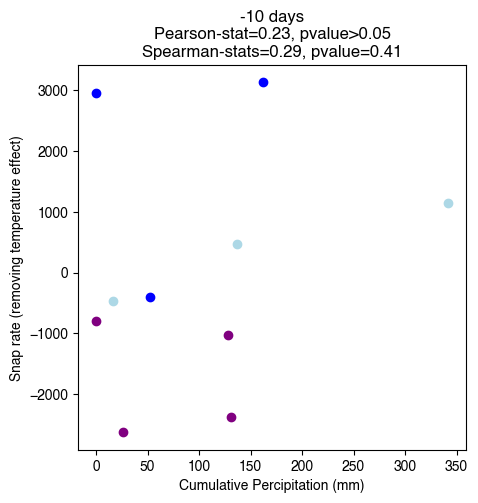

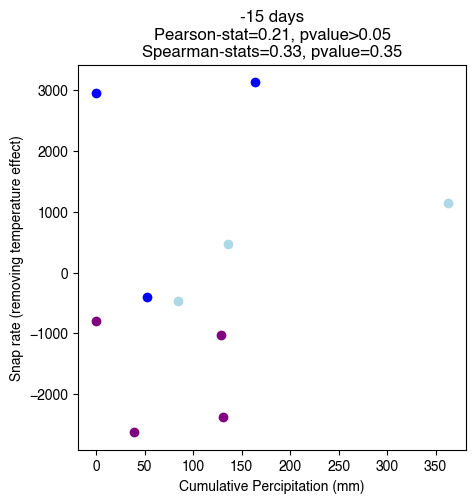

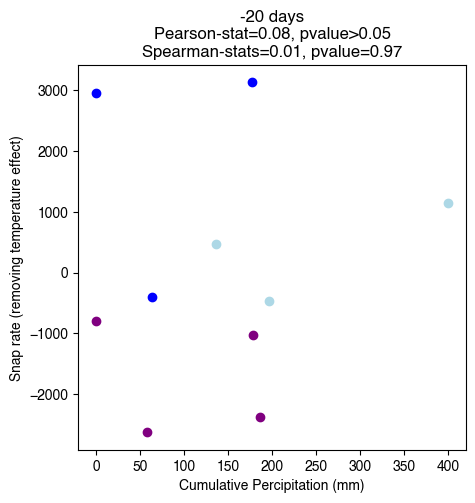

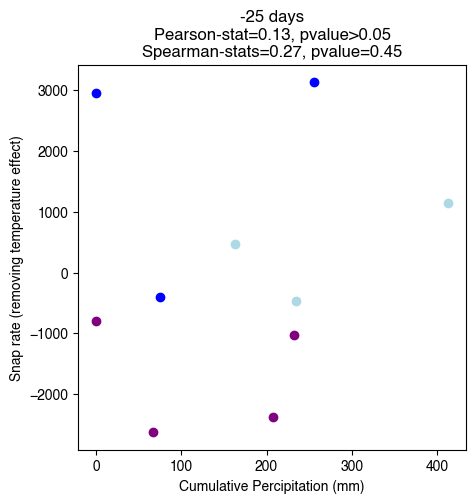

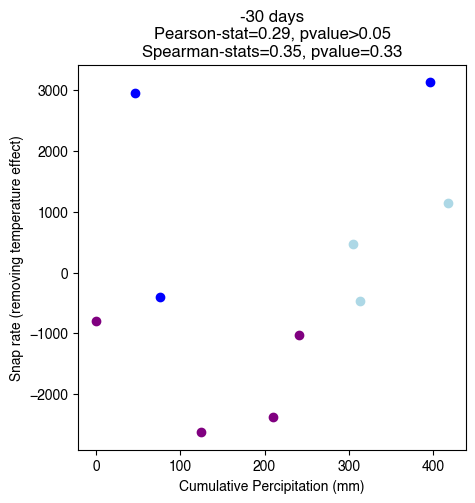

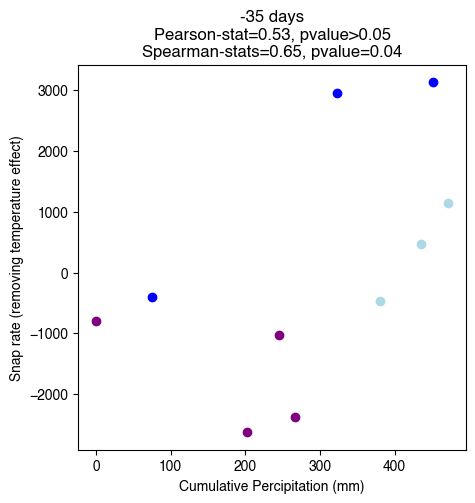

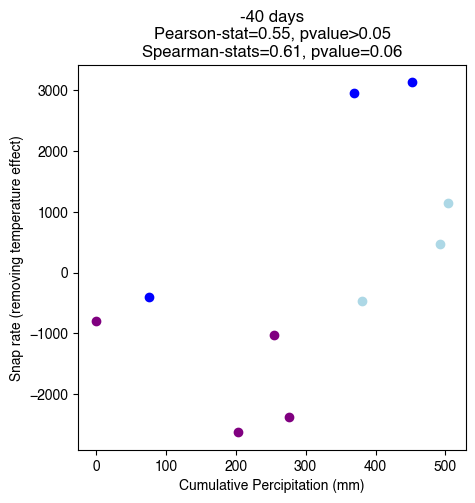

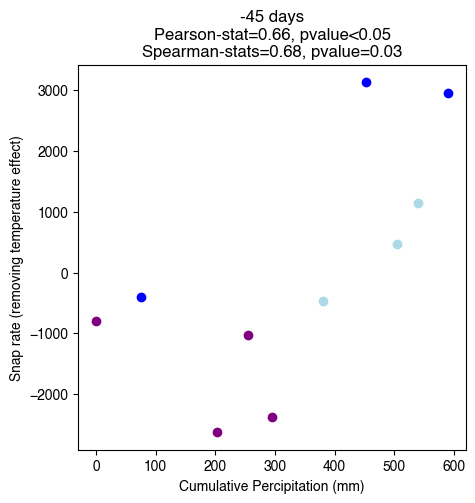

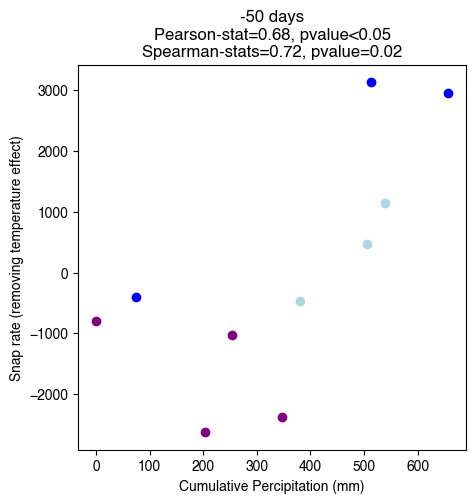

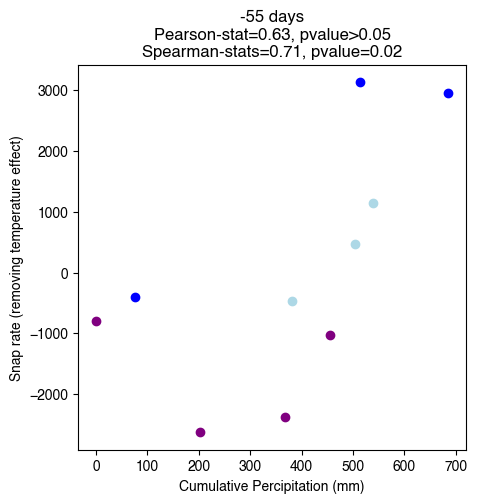

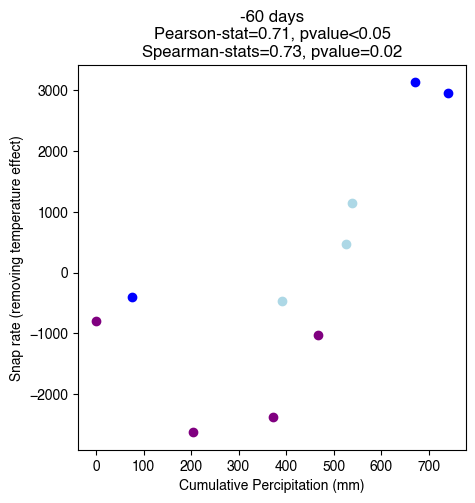

In [13]:

for day_before in [10,15,20,25,30,35,40,45,50,55,60]:
   
    plt.rcParams["font.family"] = "Helvetica"
    fig, ax = plt.subplots(1, 1, figsize=(5,5))#, sharey=True)
    stats_dict = {'rain':[], 'data':[]}
    
    
    for dirpath in sorted(glob.glob(path)):
        print(dirpath)
        timerange = dirpath.rsplit('/')[-1]
        begin = timerange.rsplit('-')[0]; end = timerange.rsplit('-')[1]
        begintime = datetime.strptime(begin, "%y%m%d")
        endtime = datetime.strptime(end, "%y%m%d")

        rainpath = glob.glob(f'/Volumes/Data/Rainfall_CWA/466940_基隆/466940_{begintime.year}.csv')[0]
        drain = pd.read_csv(rainpath)
        tmp = drain[pd.to_datetime(drain['time(UTC+8)'])<endtime][pd.to_datetime(drain['time(UTC+8)'])>=begintime+timedelta(days=-1*day_before)]
        all_rain = np.nansum(tmp['rain_in_hr'])

        alldf = pd.DataFrame()
        for filepath in sorted(glob.glob(f'{dirpath}/*.csv')):
            df = pd.read_csv(filepath)
            alldf = pd.concat([alldf, df])

        Q2 = np.percentile(alldf['Peak'], 50, interpolation='linear')


        try:
            temppath = glob.glob(f'../DataBase/Temperature/{place}/{begin[:4]}*.xlsx')[0]
            newdf = read_temp(temppath, begintime, endtime ,type='hobo')
        except:     
            tempplace = '長潭里'  if place == 'Keelung' else '竹圍' 
            temppath = glob.glob(f'../DataBase/Data_CWA/{begintime.year}_*{tempplace}*_stemp.csv')[0]
            newdf = read_temp(temppath, begintime, endtime ,type='CWA')
        median_temp = np.nanmedian(newdf['temp'])
        # print(all_rain, Q1, Q2, Q3)
        print(median_temp, all_rain, Q2)

        Q2_detrend = Q2 - temp_relation(median_temp)

        if begintime.year == 2021:
            color = 'lightblue'
        elif begintime.year == 2022:
            color = 'blue'   
        elif begintime.year == 2023:
            color = 'purple'

        plt.scatter(all_rain, Q2_detrend, color=color, marker='o')

        stats_dict['rain'].append(all_rain)
        stats_dict['data'].append(Q2_detrend)

    normalized = (stats_dict['data']-min(stats_dict['data']))/max(stats_dict['data'])

    # stats_result = scipy.stats.chi2_contingency(
    #     observed = np.array([ stats_dict['rain'], normalized])
    #  )
    stats_result = scipy.stats.pearsonr(stats_dict['rain'], stats_dict['data'])
    spearmanr_result = scipy.stats.spearmanr(stats_dict['rain'], stats_dict['data'])
    
    
    if stats_result.pvalue < 0.01:
        plt.title(f'{-1*day_before} days\nPearson-stat={round(stats_result.statistic,2)}, pvalue<0.01\nSpearman-stats={round(spearmanr_result.statistic,2)}, pvalue={round(spearmanr_result.pvalue,2)}')
    elif 0.05 > stats_result.pvalue > 0.01:
        plt.title(f'{-1*day_before} days\nPearson-stat={round(stats_result.statistic,2)}, pvalue<0.05\nSpearman-stats={round(spearmanr_result.statistic,2)}, pvalue={round(spearmanr_result.pvalue,2)}')
    else:
        plt.title(f'{-1*day_before} days\nPearson-stat={round(stats_result.statistic,2)}, pvalue>0.05\nSpearman-stats={round(spearmanr_result.statistic,2)}, pvalue={round(spearmanr_result.pvalue,2)}')
    plt.xlabel('Cumulative Percipitation (mm)')
    plt.ylabel('Snap rate (removing temperature effect)')
    